이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [ ]:
pip install openTSNE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.3 MB/s eta 0:00:00


In [ ]:
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from openTSNE import TSNE

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [ ]:
path = kagglehub.dataset_download("zalando-research/fashionmnist")
print("Path to dataset files:", path)

train_data_path = os.path.join(path, "fashion-mnist_train.csv")
test_data_path = os.path.join(path, "fashion-mnist_test.csv")

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# train 데이터, test 데이터 확인
print("Train dataset preview:")
print(train_data.head())
print("\nTest dataset preview:")
print(test_data.head())

100%|██████████| 68.8M/68.8M [00:00<00:00, 154MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4
Train dataset preview:
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [ ]:
# Train 데이터셋 요약 정보
print("Train Dataset Information:")
print("Shape:", train_data.shape)  # 데이터셋의 모양 (행, 열)
print("Size:", train_data.size)    # 총 요소 수
print("Missing Values:", train_data.isnull().sum().sum())  # 결측치 개수

Train Dataset Information:
Shape: (60000, 785)
Size: 47100000
Missing Values: 0


In [ ]:
# Test 데이터셋 요약 정보
print("\nTest Dataset Information:")
print("Shape:", test_data.shape)
print("Size:", test_data.size)
print("Missing Values:", test_data.isnull().sum().sum())


Test Dataset Information:
Shape: (10000, 785)
Size: 7850000
Missing Values: 0


In [ ]:
print("Fashion MNIST train -  rows:",train_data.shape[0]," columns:", train_data.shape[1])
print("Fashion MNIST test -  rows:",test_data.shape[0]," columns:", test_data.shape[1])

Fashion MNIST train -  rows: 60000  columns: 785
Fashion MNIST test -  rows: 10000  columns: 785


### Data중 첫 번째 이미지를 보여주세요.

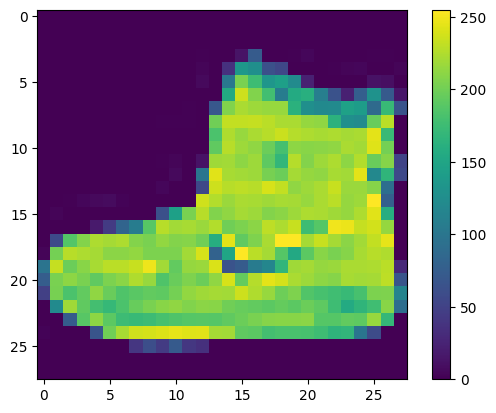

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

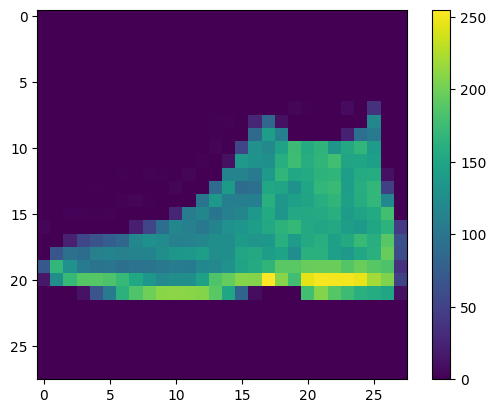

In [ ]:
plt.figure()
plt.imshow(test_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [ ]:
# 이미지 데이터를 PyTorch의 Tensor로 변환하고, 정규화
train_images = torch.tensor(train_images, dtype=torch.float32) / 255.0  # 0-255 -> 0-1
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_images = torch.tensor(test_images, dtype=torch.float32) / 255.0    # 0-255 -> 0-1
test_labels = torch.tensor(test_labels, dtype=torch.long)

### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

In [ ]:
# 추가 전처리: 평균과 표준편차를 이용한 표준화
train_mean = train_images.mean()
train_std = train_images.std()

train_images = (train_images - train_mean) / train_std
test_images = (test_images - train_mean) / train_std

# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

- PCA (주성분 분석)

목적: 데이터의 분산을 최대한 유지하며 고차원 데이터를 저차원으로 압축.

방법: 데이터의 주성분(분산이 가장 큰 방향의 축)을 찾아서 해당 축을 기준으로 투영.

특징: 선형 변환 기법으로, 고차원의 선형적인 구조를 잘 유지하지만, 비선형 구조에 한계가 있음.

사용 사례: 데이터의 주요 특징을 찾고 압축할 때 유용 (예: 이미지, 텍스트 데이터).

- t-SNE (t-분포 확률적 이웃 임베딩)

목적: 데이터 포인트 간의 국소적인 유사성을 잘 유지하면서 시각화용 저차원 공간으로 변환.

방법: 데이터 간의 유사성을 확률로 계산하여 저차원에서도 유사한 구조를 재현하도록 배치.

특징: 비선형 변환 기법으로, 데이터의 복잡한 비선형 구조를 잘 반영함. 하지만 계산 비용이 높고, 고차원 특징의 전반적인 분산 유지에는 적합하지 않음.

사용 사례: 데이터의 시각화가 중요한 경우 (예: 이미지, 텍스트 클러스터링 시 시각화).

## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [ ]:
from sklearn.decomposition import PCA

# (60000, 28, 28) -> (60000, 784) 형태로 변환
train_images_np = train_images.view(train_images.shape[0], -1).numpy()
test_images_np = test_images.view(test_images.shape[0], -1).numpy()

pca = PCA(n_components=50)
train_images_pca = pca.fit_transform(train_images_np)
test_images_pca = pca.transform(test_images_np)

print("Train images after PCA:", train_images_pca.shape)
print("Test images after PCA:", test_images_pca.shape)

Train images after PCA: (60000, 50)
Test images after PCA: (10000, 50)


### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_

print("Explained variance ratio for each component:", explained_variance_ratio)
print("Total explained variance by 50 components:", explained_variance_ratio.sum())

Explained variance ratio for each component: [0.2903673  0.17753293 0.06018337 0.04956472 0.03847159 0.0346037
 0.02341374 0.01905259 0.0134968  0.01314342 0.00992739 0.00913219
 0.00765638 0.00659621 0.00607828 0.00589736 0.00552191 0.00524499
 0.00458014 0.00455715 0.0043366  0.00407031 0.00384713 0.00372497
 0.00361133 0.0035062  0.00333204 0.00319302 0.00308079 0.00293268
 0.00275571 0.00265049 0.00263867 0.002558   0.00246248 0.00235932
 0.00230319 0.00225513 0.00218491 0.0020931  0.00200264 0.0019579
 0.0019467  0.00182769 0.00175447 0.00171917 0.00168774 0.00163941
 0.00160903 0.00154862]
Total explained variance by 50 components: 0.8626116


### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [ ]:
from sklearn.metrics import mean_squared_error

train_images_reconstructed = pca.inverse_transform(train_images_pca)

reconstruction_error = mean_squared_error(train_images_np, train_images_reconstructed)

print("Reconstruction Error (MSE):", reconstruction_error)

Reconstruction Error (MSE): 0.09586445


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [ ]:
pca_30 = PCA(n_components=30)
train_images_pca_30 = pca_30.fit_transform(train_images_np)
test_images_pca_30 = pca_30.transform(test_images_np)

explained_variance_ratio_30 = pca_30.explained_variance_ratio_
total_explained_variance_30 = explained_variance_ratio_30.sum()

train_images_reconstructed_30 = pca_30.inverse_transform(train_images_pca_30)
reconstruction_error_30 = mean_squared_error(train_images_np, train_images_reconstructed_30)

print("Total Explained Variance (30 components):", total_explained_variance_30)
print("Reconstruction Error (MSE) with 30 components:", reconstruction_error_30)

Total Explained Variance (30 components): 0.8206571
Reconstruction Error (MSE) with 30 components: 0.12515362


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

- 50차원일 때 데이터의 약 86.3%의 분산을 유지. 30차원으로 축소하면 약 82.1%만 유지하게 됩니다. -> 차원이 낮아지면서 데이터의 일부 중요한 정보를 더 많이 잃게 되는 결과

- 50차원일 때 재구성 오차(MSE)는 0.0959로, 원본 데이터와의 차이가 비교적 적음. 30차원일 때 재구성 오차는 0.1252로 증가하여, 데이터가 덜 정확하게 복원. -> 차원이 더 낮아짐에 따라 정보 손실이 커져, 복원된 데이터와 원본 데이터의 차이가 더 커짐

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [ ]:
pca_2 = PCA(n_components=2)
train_images_pca_2 = pca_2.fit_transform(train_images_np)
test_images_pca_2 = pca_2.transform(test_images_np)

explained_variance_ratio_2 = pca_2.explained_variance_ratio_
total_explained_variance_2 = explained_variance_ratio_2.sum()

train_images_reconstructed_2 = pca_2.inverse_transform(train_images_pca_2)
reconstruction_error_2 = mean_squared_error(train_images_np, train_images_reconstructed_2)

print("Total Explained Variance (2 components):", total_explained_variance_2)
print("Reconstruction Error (MSE) with 2 components:", reconstruction_error_2)

Total Explained Variance (2 components): 0.46790022
Reconstruction Error (MSE) with 2 components: 0.37146246


### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

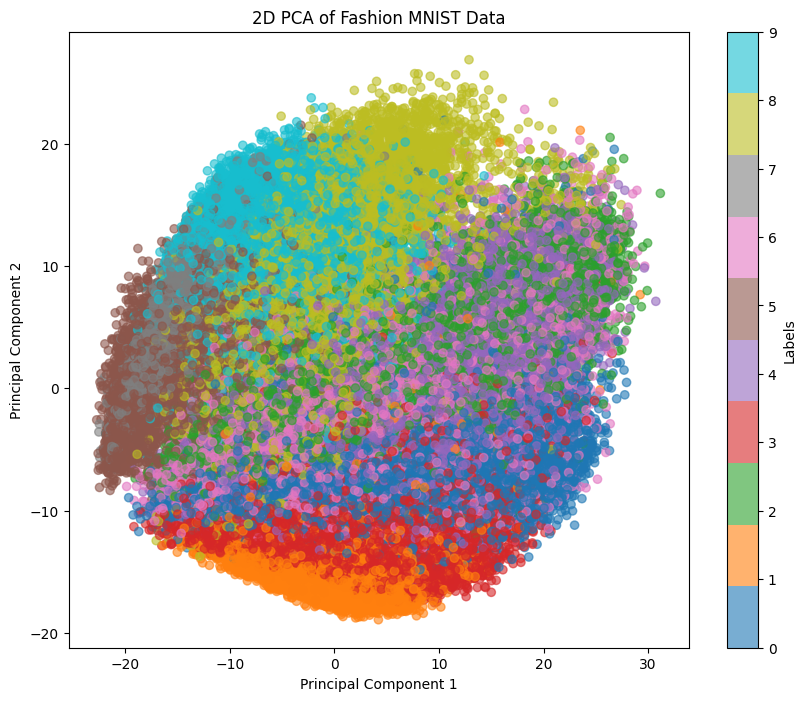

In [ ]:
train_labels_np = train_labels.numpy()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_pca_2[:, 0], train_images_pca_2[:, 1], c=train_labels_np, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label="Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA of Fashion MNIST Data")
plt.show()

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
train_images_tsne = tsne.fit_transform(train_images_pca)

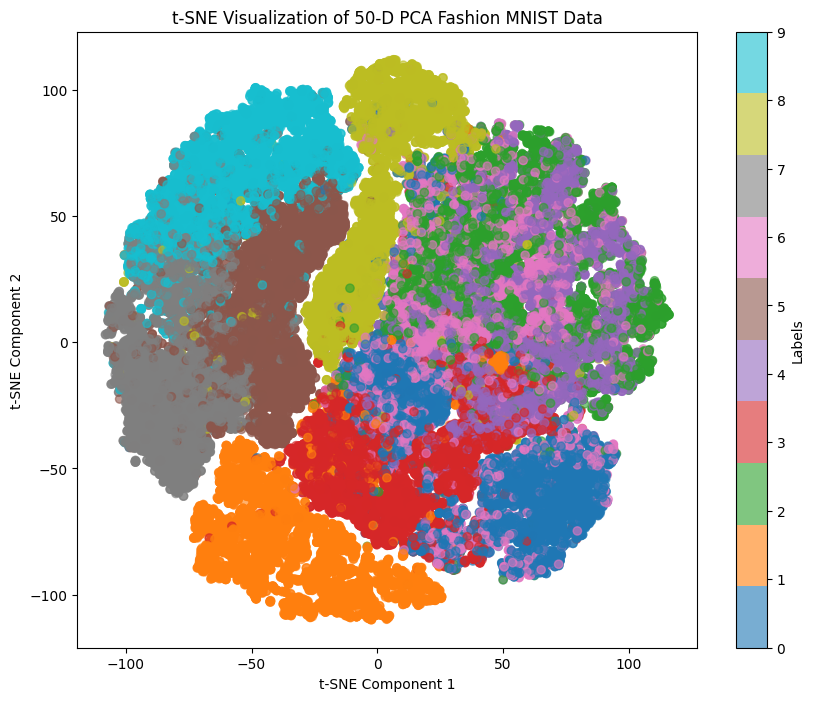

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne[:, 0], train_images_tsne[:, 1], c=train_labels_np, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label="Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of 50-D PCA Fashion MNIST Data")
plt.show()

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

In [ ]:
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
train_images_tsne_30 = tsne.fit_transform(train_images_pca_30)

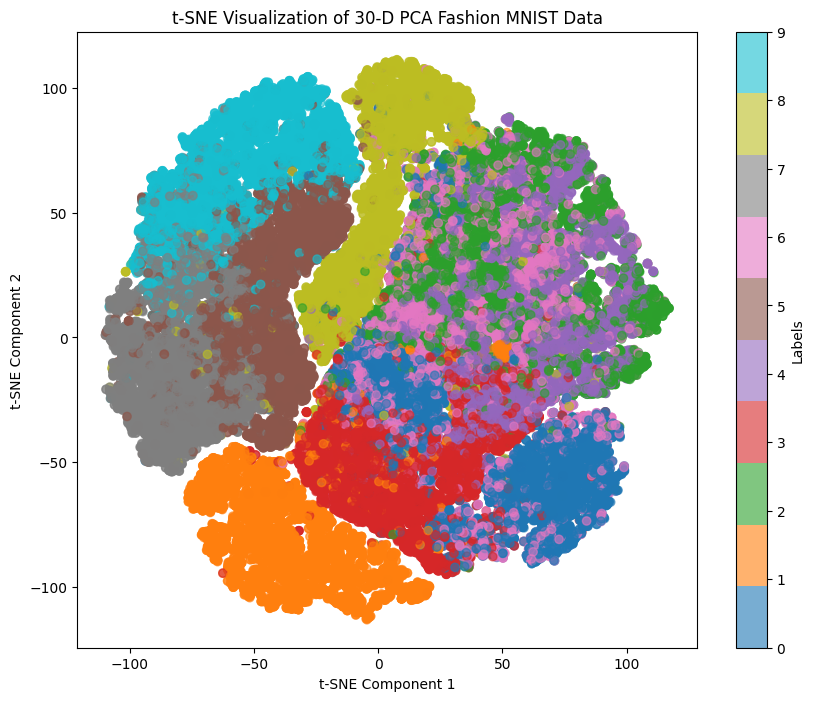

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne_30[:, 0], train_images_tsne_30[:, 1], c=train_labels_np, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label="Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of 30-D PCA Fashion MNIST Data")
plt.show()

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [ ]:
dbscan = DBSCAN(eps=3, min_samples=5)  # eps와 min_samples는 데이터에 맞게 조정 가능
dbscan_labels = dbscan.fit_predict(train_images_pca)

core_samples_mask = dbscan_labels != -1
if len(set(dbscan_labels)) > 1:
    silhouette_avg = silhouette_score(train_images_pca[core_samples_mask], dbscan_labels[core_samples_mask])
else:
    silhouette_avg = "Silhouette score unavailable (fewer than 2 clusters)"

print("DBSCAN Labels:", dbscan_labels)
print("Silhouette Score:", silhouette_avg)

DBSCAN Labels: [-1 -1 -1 ... -1 -1 -1]
Silhouette Score: 0.19368576


### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(train_images_pca)

silhouette_avg_kmeans = silhouette_score(train_images_pca, kmeans_labels)

print("K-Means Labels:", kmeans_labels)
print("Silhouette Score for K-Means:", silhouette_avg_kmeans)

K-Means Labels: [5 7 9 ... 0 9 9]
Silhouette Score for K-Means: 0.17263


### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

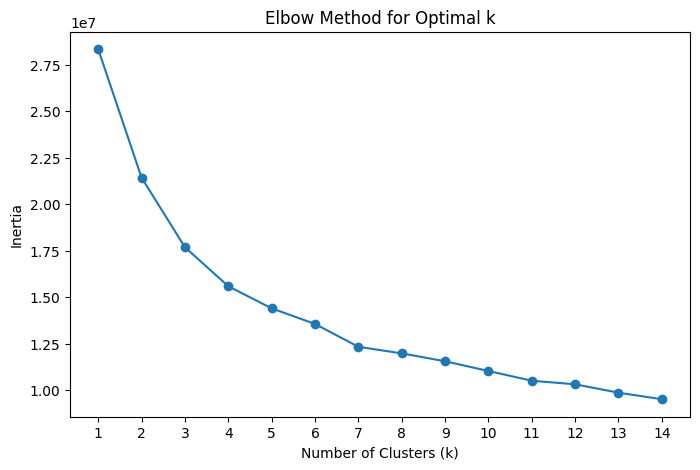

In [ ]:
inertia_values = []  # 각 k 값에 대한 inertia 저장 리스트
k_values = range(1, 15)  # 군집 개수 범위 설정

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_images_pca)
    inertia_values.append(kmeans.inertia_)

# 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values)
plt.show()

### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

In [ ]:
inertia_diff = np.diff(inertia_values)
optimal_k = k_values[np.argmin(inertia_diff) + 1]

optimal_k

2

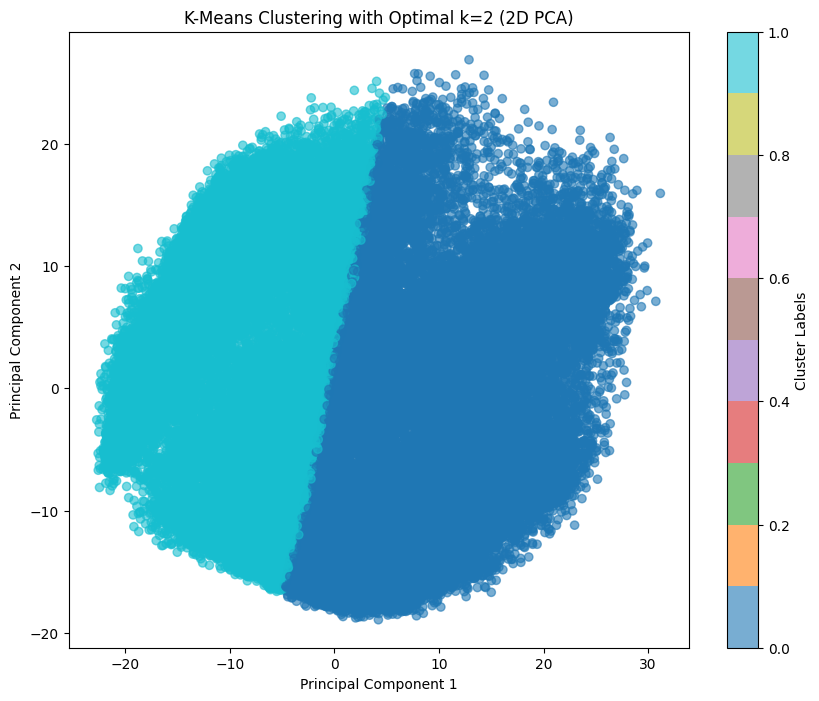

In [ ]:
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels_optimal = kmeans_optimal.fit_predict(train_images_pca)

pca_2d = PCA(n_components=2)
train_images_pca_2d = pca_2d.fit_transform(train_images_pca)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_pca_2d[:, 0], train_images_pca_2d[:, 1], c=kmeans_labels_optimal, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label="Cluster Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"K-Means Clustering with Optimal k={optimal_k} (2D PCA)")
plt.show()

In [ ]:
silhouette_avg_kmeans = silhouette_score(train_images_pca, kmeans_labels_optimal)

print("Silhouette Score for K-Means with k =", optimal_k, ":", silhouette_avg_kmeans)

Silhouette Score for K-Means with k = 2 : 0.22343142


In [ ]:
optimal_k = 6

kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels_optimal = kmeans_optimal.fit_predict(train_images_pca)

pca_2d = PCA(n_components=2)
train_images_pca_2d = pca_2d.fit_transform(train_images_pca)

silhouette_avg_kmeans = silhouette_score(train_images_pca, kmeans_labels_optimal)

print("Silhouette Score for K-Means with k =", optimal_k, ":", silhouette_avg_kmeans)

Silhouette Score for K-Means with k = 6 : 0.20063393


### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

- Mean Shift Clustering

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [ ]:
bandwidth = estimate_bandwidth(train_images_pca, quantile=0.2, n_samples=500)

mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mean_shift_labels = mean_shift.fit_predict(train_images_pca)

n_clusters = len(set(mean_shift_labels)) - (1 if -1 in mean_shift_labels else 0)
print(f"Estimated number of clusters: {n_clusters}")

Estimated number of clusters: 1


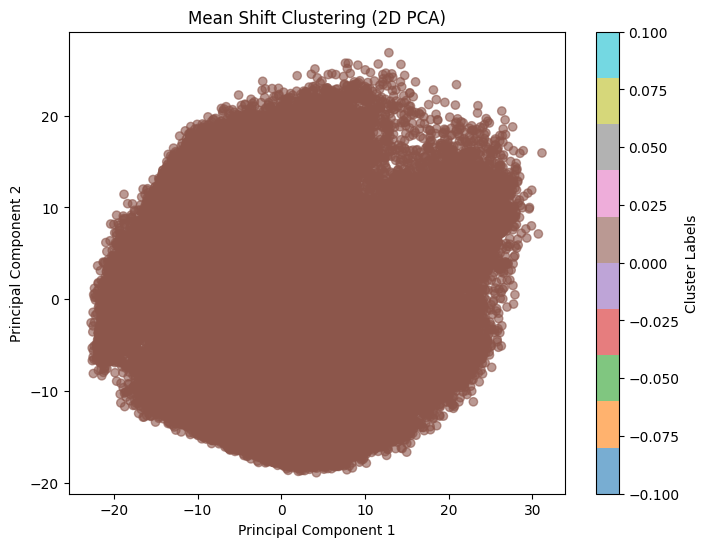

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(train_images_pca[:, 0], train_images_pca[:, 1], c=mean_shift_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label="Cluster Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Mean Shift Clustering (2D PCA)")
plt.show()

In [19]:
initial_bandwidth = estimate_bandwidth(train_images_pca, quantile=0.2, n_samples=500)
bandwidth = initial_bandwidth
n_clusters = 1

In [20]:
while n_clusters <= 1:
    mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    mean_shift_labels = mean_shift.fit_predict(train_images_pca)

    # 군집 개수 확인 (노이즈 레이블 제외)
    n_clusters = len(set(mean_shift_labels)) - (1 if -1 in mean_shift_labels else 0)
    print(f"Trying bandwidth={bandwidth:.2f} -> Estimated number of clusters: {n_clusters}")

    # bandwidth 값을 점진적으로 줄임
    bandwidth *= 0.9  # 10%씩 줄여가며 시도

print(f"\nOptimal bandwidth={bandwidth / 0.9:.2f} with estimated number of clusters: {n_clusters}")

Trying bandwidth=23.46 -> Estimated number of clusters: 1
Trying bandwidth=21.11 -> Estimated number of clusters: 1
Trying bandwidth=19.00 -> Estimated number of clusters: 1
Trying bandwidth=17.10 -> Estimated number of clusters: 3

Optimal bandwidth=17.10 with estimated number of clusters: 3


In [21]:
optimal_bandwidth = 17.10
mean_shift = MeanShift(bandwidth=optimal_bandwidth, bin_seeding=True)
mean_shift_labels = mean_shift.fit_predict(train_images_pca)

In [25]:
# 실루엣 점수 계산
silhouette_avg_mean_shift = silhouette_score(train_images_pca, mean_shift_labels)
print(f"Silhouette Score for Mean Shift with bandwidth={optimal_bandwidth}: {silhouette_avg_mean_shift}")

Silhouette Score for Mean Shift with bandwidth=17.1: 0.19383825361728668


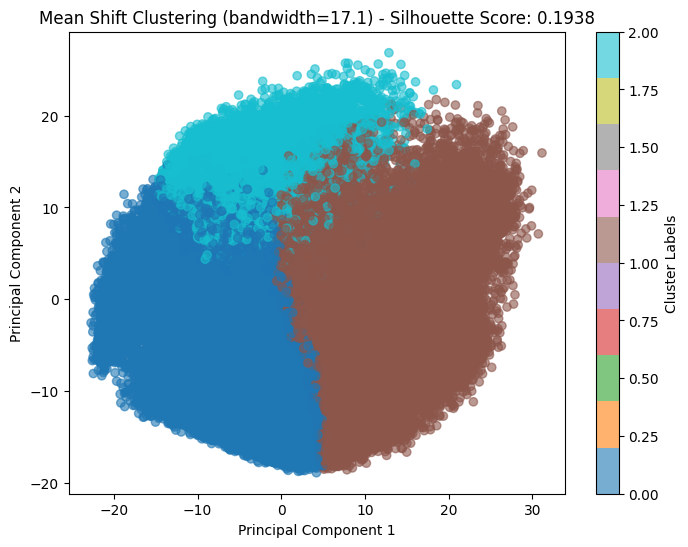

In [26]:
pca_2d = PCA(n_components=2)
train_images_pca_2d = pca_2d.fit_transform(train_images_pca)

# 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(train_images_pca_2d[:, 0], train_images_pca_2d[:, 1], c=mean_shift_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label="Cluster Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"Mean Shift Clustering (bandwidth={optimal_bandwidth}) - Silhouette Score: {silhouette_avg_mean_shift:.4f}")
plt.show()

- Mini-Batch K-Means

In [27]:
from sklearn.cluster import MiniBatchKMeans

In [30]:
optimal_k = 3

pca = PCA(n_components=2)
train_images_pca_2d = pca.fit_transform(train_images_pca)

mini_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=100)
mini_kmeans_labels = mini_kmeans.fit_predict(train_images_pca_2d)

In [31]:
silhouette_avg_mini_kmeans = silhouette_score(train_images_pca_2d, mini_kmeans_labels)
print(f"Silhouette Score for Mini-Batch K-Means with k={optimal_k}: {silhouette_avg_mini_kmeans}")

Silhouette Score for Mini-Batch K-Means with k=3: 0.4067278504371643


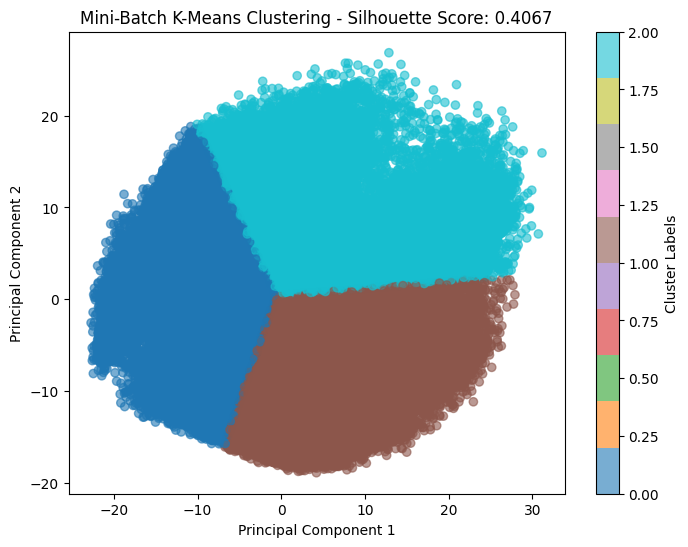

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(train_images_pca_2d[:, 0], train_images_pca_2d[:, 1], c=mini_kmeans_labels, cmap='tab10', alpha=0.6)
plt.colorbar(label="Cluster Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"Mini-Batch K-Means Clustering - Silhouette Score: {silhouette_avg_mini_kmeans:.4f}")
plt.show()

In [33]:
pca = PCA(n_components=2)
train_images_pca_2d = pca.fit_transform(train_images_pca)

In [34]:
cluster_range = range(2, 10)
silhouette_scores = []

In [35]:
for k in cluster_range:
    mini_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
    labels = mini_kmeans.fit_predict(train_images_pca_2d)
    silhouette_avg = silhouette_score(train_images_pca_2d, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Number of clusters: {k}, Silhouette Score: {silhouette_avg:.4f}")

Number of clusters: 2, Silhouette Score: 0.3978
Number of clusters: 3, Silhouette Score: 0.4067
Number of clusters: 4, Silhouette Score: 0.4438
Number of clusters: 5, Silhouette Score: 0.4224
Number of clusters: 6, Silhouette Score: 0.4142
Number of clusters: 7, Silhouette Score: 0.4087
Number of clusters: 8, Silhouette Score: 0.4074
Number of clusters: 9, Silhouette Score: 0.4136


In [36]:
optimal_k = cluster_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")


Optimal number of clusters: 4


In [57]:
optimal_k = 4

mini_kmeans_optimal = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=100)
mini_kmeans_labels_optimal = mini_kmeans_optimal.fit_predict(train_images_pca_2d)

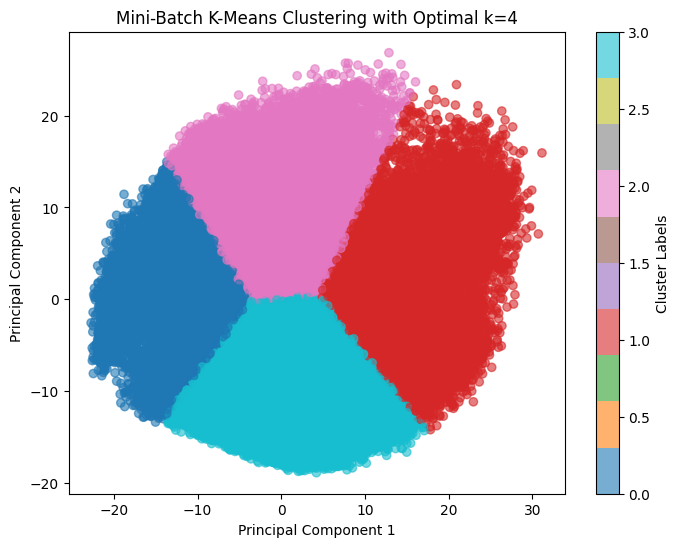

In [58]:
plt.figure(figsize=(8, 6))
plt.scatter(train_images_pca_2d[:, 0], train_images_pca_2d[:, 1], c=mini_kmeans_labels_optimal, cmap='tab10', alpha=0.6)
plt.colorbar(label="Cluster Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"Mini-Batch K-Means Clustering with Optimal k={optimal_k}")
plt.show()

- Birch (Balanced Iterative Reducing and Clustering using Hierarchies)

In [41]:
from sklearn.cluster import Birch

In [39]:
cluster_range = range(2, 10)
silhouette_scores = []

In [42]:
for k in cluster_range:
    birch = Birch(n_clusters=k)
    birch_labels = birch.fit_predict(train_images_pca_2d)

    # 군집 수가 1보다 큰 경우에만 실루엣 점수 계산
    n_clusters = len(set(birch_labels))
    if n_clusters > 1:
        silhouette_avg = silhouette_score(train_images_pca_2d, birch_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Number of clusters: {k}, Silhouette Score: {silhouette_avg:.4f}")
    else:
        silhouette_scores.append(-1)

Number of clusters: 2, Silhouette Score: 0.3109
Number of clusters: 3, Silhouette Score: 0.2751
Number of clusters: 4, Silhouette Score: 0.3406
Number of clusters: 5, Silhouette Score: 0.2978
Number of clusters: 6, Silhouette Score: 0.3178
Number of clusters: 7, Silhouette Score: 0.3248
Number of clusters: 8, Silhouette Score: 0.3554
Number of clusters: 9, Silhouette Score: 0.3495


In [43]:
optimal_k = cluster_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")


Optimal number of clusters: 8


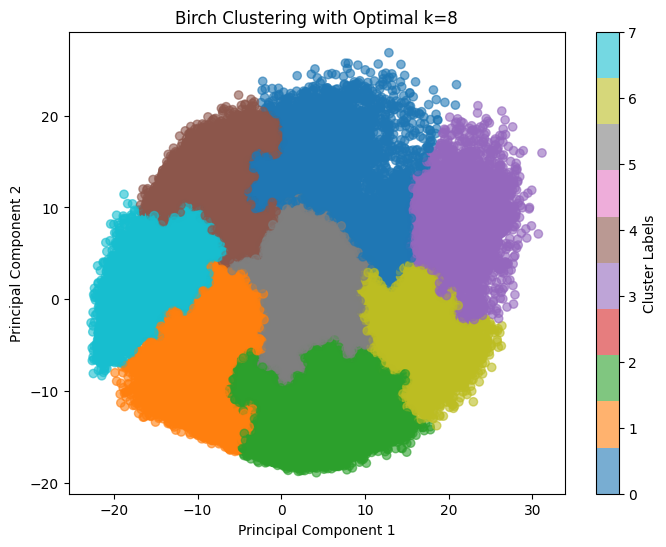

In [44]:
birch_optimal = Birch(n_clusters=optimal_k)
birch_labels_optimal = birch_optimal.fit_predict(train_images_pca_2d)

plt.figure(figsize=(8, 6))
plt.scatter(train_images_pca_2d[:, 0], train_images_pca_2d[:, 1], c=birch_labels_optimal, cmap='tab10', alpha=0.6)
plt.colorbar(label="Cluster Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"Birch Clustering with Optimal k={optimal_k}")
plt.show()

In [45]:
silhouette_avg_birch = silhouette_score(train_images_pca_2d, birch_labels_optimal)
print("Silhouette Score for Birch Clustering with Optimal k:", silhouette_avg_birch)

Silhouette Score for Birch Clustering with Optimal k: 0.3553867


- HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)

In [47]:
pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 30.5 MB/s eta 0:00:00


In [48]:
import hdbscan

In [49]:
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=50)
hdbscan_labels = hdbscan_cluster.fit_predict(train_images_pca)

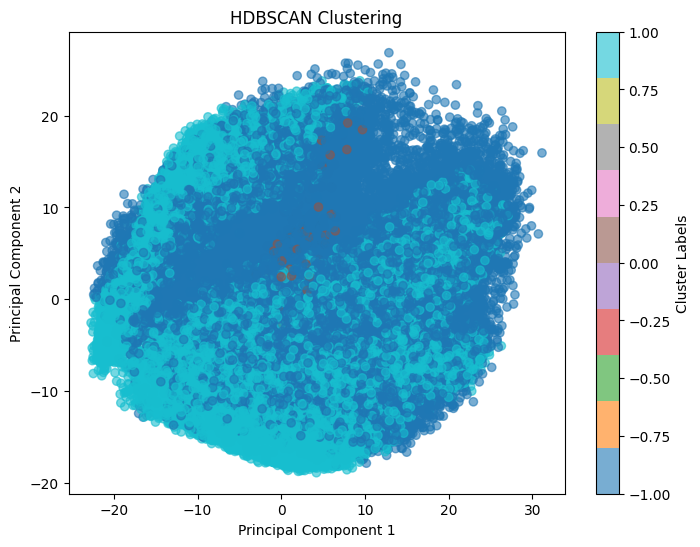

In [50]:
plt.figure(figsize=(8, 6))
plt.scatter(train_images_pca[:, 0], train_images_pca[:, 1], c=hdbscan_labels, cmap='tab10', alpha=0.6)
plt.colorbar(label="Cluster Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("HDBSCAN Clustering")
plt.show()

In [51]:
silhouette_avg_hdbscan = silhouette_score(train_images_pca[hdbscan_labels != -1], hdbscan_labels[hdbscan_labels != -1])
print("Silhouette Score for HDBSCAN Clustering:", silhouette_avg_hdbscan)

Silhouette Score for HDBSCAN Clustering: 0.13176471


## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.

- 1에 가까울수록 각 데이터 포인트가 잘 분리된 군집에 속해 있으며, 군집 내에서 데이터 포인트들이 밀집되어 있다는 의미입니다. 즉, 군집화가 잘 이루어진 상태입니다.

- 가장 높은 실루엣 점수를 기록한 **Mini-Batch K-Means (k=4)**가 데이터 구조를 가장 잘 반영하는 모델

- Mini-Batch K-Means는 대규모 데이터에서 빠른 성능을 보이며 실루엣 점수도 높아 추천